# IMDB movie review sentiment classification using recurent neural networks

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from tqdm import tqdm
tqdm.pandas()
from torch.utils.data.sampler import SubsetRandomSampler
import time

## Loading IMDB data

In [265]:
input_dim = 20000
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.imdb.load_data(num_words=input_dim)
print(f'Training sequences: {len(x_train_all)}')
print(f'Test sequences: {len(x_test_all)}')

Training sequences: 25000
Test sequences: 25000


## Cutting sequences lenght

In [266]:
maxlen = 100 #max sequence lenght
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_all, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_all, maxlen=maxlen)

In [267]:
x_train.shape

(25000, 100)

## Sample review recovery

In [268]:
offset = 3
word_index = tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")
word_index = {word: (i + offset) for word,i in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
index_to_word = { v: k for k, v in word_index.items()}

def recover_text(sample, index_to_word):
 return ' '.join([index_to_word[i] for i in sample])

recover_text(x_train[19], index_to_word)

"college and encountering a young man robert downey jr who it turns out is the reincarnation of her father the film is a little on the predictable side the story goes all the places you expect it to but it is so charmingly played by an energetic cast especially shepherd and downey that you can't help but get wrapped up in the fun shepherd has rarely been seen on screen to better advantage and she and downey are backed by a talented group of character actors in supporting roles a lovely and charming fantasy that will <UNK> and <UNK> you"

# PYTORCH

### Transforming data using DataLoader to batches and tensors

In [269]:
batch_size=64
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train_all))
valid_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test_all))
#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
#valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)


### Chosing training subset

In [271]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(train_data)))
train_sample = SubsetRandomSampler(indices[:split])
val_sample = SubsetRandomSampler(indices[-4000:])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, drop_last=True, sampler=train_sample)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, drop_last=True, sampler=val_sample)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

## LSTM model

In [272]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.embedding(x.long())
        x, _ =  self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

## Model initialization

In [273]:
model = LSTMModel(input_dim, 1, 128, maxlen, 2, 0.1)
print(model)

LSTMModel(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training 

In [274]:
def train_model(model, train_loader, valid_loader, lr = 0.001, epochs = 8):
    loss_fn = nn.BCELoss()
    optim = Adam(model.parameters(), lr=lr)
    grad_clip = 5

    epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss = [],[],[],[]

    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    for e in epochloop:

        model.train()
        train_loss = 0
        train_acc = 0

        for i, (x, y) in enumerate(train_loader):

            epochloop.set_postfix_str(f'Training batch {i}/{len(train_loader)}')

            optim.zero_grad()

            output = model(x)

            predicted = torch.tensor([1 if ii == True else 0 for ii in output > 0.5])
            equals = predicted == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()
            loss = loss_fn(output.squeeze(), y.float())
            train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optim.step()

            del x, y, predicted
        val_loss, val_acc = validate(model, valid_loader)
        epoch_val_accs.append(val_acc)
        epoch_val_loss.append(val_loss)
        epoch_train_loss.append(train_loss / len(train_loader))
        epoch_train_accs.append(train_acc / len(train_loader) )
        epochloop.set_postfix_str(f'Validation Loss: {val_loss:.3f} | Validation Accuracy: {val_acc:.3f}')
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss:.3f} Val Acc: {val_acc:.3f}')
        epochloop.update()    
    return epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss    

      
def validate(model, valid_loader):
    loss_fn = nn.BCELoss()
    
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            
            output = model(x)
            predicted = torch.tensor([1 if ii == True else 0 for ii in output > 0.5])
            equals = predicted == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()
            loss = loss_fn(output.squeeze(), y.float())
            val_loss += loss.item()

            del x, y, predicted
    return val_loss/len(valid_loader), val_acc/len(valid_loader)

In [252]:
epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss = train_model(model, train_loader, valid_loader)

Training:  25%|██▌       | 2/8 [00:16<01:40, 16.68s/it, Training batch 1/78]                                

Epoch 1/8 | Train Loss: 0.663 Train Acc: 0.598 | Val Loss: 0.604 Val Acc: 0.676


Training:  50%|█████     | 4/8 [00:34<00:42, 10.74s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.577 Train Acc: 0.696 | Val Loss: 0.585 Val Acc: 0.693


Training:  62%|██████▎   | 5/8 [00:51<00:29,  9.81s/it, Training batch 0/78]                                

Epoch 3/8 | Train Loss: 0.479 Train Acc: 0.776 | Val Loss: 0.554 Val Acc: 0.732


Training:  88%|████████▊ | 7/8 [01:13<00:12, 12.87s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.388 Train Acc: 0.827 | Val Loss: 0.538 Val Acc: 0.726


Training: 100%|██████████| 8/8 [01:33<00:00, 11.59s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.292 Train Acc: 0.876 | Val Loss: 0.532 Val Acc: 0.759


Training: 9it [01:51, 13.20s/it, Training batch 0/78]                                                       

Epoch 6/8 | Train Loss: 0.209 Train Acc: 0.916 | Val Loss: 0.621 Val Acc: 0.768


Training: 11it [02:14, 15.78s/it, Training batch 1/78]                                

Epoch 7/8 | Train Loss: 0.124 Train Acc: 0.955 | Val Loss: 0.730 Val Acc: 0.759


Training: 100%|██████████| 8/8 [02:33<00:00, 19.24s/it, Validation Loss: 0.864 | Validation Accuracy: 0.755]

Epoch 8/8 | Train Loss: 0.097 Train Acc: 0.964 | Val Loss: 0.864 Val Acc: 0.755


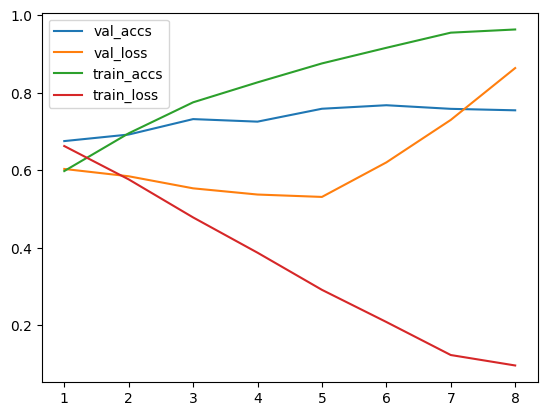

In [254]:
epoch_num = [i+1 for i in range(8) ]
 
plt.plot(epoch_num, epoch_val_accs, label='val_accs')
plt.plot(epoch_num, epoch_val_loss,  label='val_loss')
plt.plot(epoch_num, epoch_train_accs, label='train_accs')
plt.plot(epoch_num, epoch_train_loss,  label='train_loss')
plt.legend(loc='best')
plt.show()

In [153]:
test_loss, test_accuracy = validate(test_loader)
print(f'Test loss: {test_loss} | Test accuracy: {test_accuracy}')

Test loss: 0.5561053054716886 | Test accuracy: 0.7536365089514067


In [247]:
def heatmap(columns, rows, scores):
    plt.figure() 
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")    

c:\Users\karol\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Training:   0%|          | 0/8 [00:00<?, ?it/s, Training batch 0/78]

Training:  25%|██▌       | 2/8 [00:05<00:30,  5.07s/it, Training batch 3/78]                                

Epoch 1/8 | Train Loss: 0.688 Train Acc: 0.532 | Val Loss: 0.674 Val Acc: 0.574


Training:  50%|█████     | 4/8 [00:09<00:11,  2.88s/it, Training batch 4/78]                                

Epoch 2/8 | Train Loss: 0.660 Train Acc: 0.603 | Val Loss: 0.647 Val Acc: 0.620


Training:  62%|██████▎   | 5/8 [00:13<00:07,  2.50s/it, Training batch 3/78]                                

Epoch 3/8 | Train Loss: 0.590 Train Acc: 0.695 | Val Loss: 0.589 Val Acc: 0.680


Training:  88%|████████▊ | 7/8 [00:18<00:02,  2.99s/it, Training batch 4/78]                                

Epoch 4/8 | Train Loss: 0.490 Train Acc: 0.768 | Val Loss: 0.544 Val Acc: 0.724


Training: 100%|██████████| 8/8 [00:22<00:00,  2.64s/it, Training batch 3/78]                                

Epoch 5/8 | Train Loss: 0.400 Train Acc: 0.827 | Val Loss: 0.524 Val Acc: 0.753


Training: 9it [00:27,  3.27s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.305 Train Acc: 0.876 | Val Loss: 0.528 Val Acc: 0.753


Training: 11it [00:33,  3.81s/it, Training batch 3/78]                                

Epoch 7/8 | Train Loss: 0.232 Train Acc: 0.919 | Val Loss: 0.602 Val Acc: 0.759


Training: 100%|██████████| 8/8 [00:38<00:00,  4.75s/it, Validation Loss: 0.622 | Validation Accuracy: 0.765]


Epoch 8/8 | Train Loss: 0.171 Train Acc: 0.941 | Val Loss: 0.622 Val Acc: 0.765
Results for LSTM with layers = 1 and hidden size = 32 : test accuracy = 0.76 | train accuracy = 0.96 | training time = 38.03491568565369
--------------------------------------------------------------------------------------------------


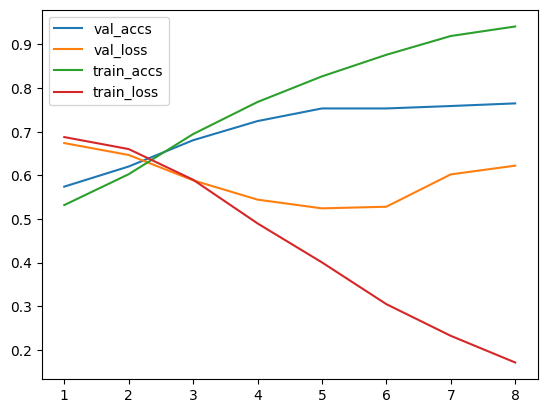

Training:  25%|██▌       | 2/8 [00:06<00:40,  6.79s/it, Training batch 2/78]                                

Epoch 1/8 | Train Loss: 0.690 Train Acc: 0.527 | Val Loss: 0.676 Val Acc: 0.580


Training:  50%|█████     | 4/8 [00:13<00:17,  4.25s/it, Training batch 2/78]                                

Epoch 2/8 | Train Loss: 0.644 Train Acc: 0.629 | Val Loss: 0.639 Val Acc: 0.627


Training:  62%|██████▎   | 5/8 [00:20<00:11,  3.79s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.549 Train Acc: 0.720 | Val Loss: 0.571 Val Acc: 0.696


Training:  88%|████████▊ | 7/8 [00:26<00:04,  4.49s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.436 Train Acc: 0.805 | Val Loss: 0.521 Val Acc: 0.746


Training: 100%|██████████| 8/8 [00:33<00:00,  3.96s/it, Training batch 2/78]                                

Epoch 5/8 | Train Loss: 0.335 Train Acc: 0.856 | Val Loss: 0.511 Val Acc: 0.755


Training: 9it [00:40,  4.74s/it, Training batch 2/78]                                                       

Epoch 6/8 | Train Loss: 0.242 Train Acc: 0.911 | Val Loss: 0.575 Val Acc: 0.746


Training: 11it [00:47,  5.22s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.173 Train Acc: 0.937 | Val Loss: 0.559 Val Acc: 0.769


Training: 100%|██████████| 8/8 [00:53<00:00,  6.72s/it, Validation Loss: 0.591 | Validation Accuracy: 0.776]


Epoch 8/8 | Train Loss: 0.135 Train Acc: 0.955 | Val Loss: 0.591 Val Acc: 0.776
Results for LSTM with layers = 1 and hidden size = 64 : test accuracy = 0.77 | train accuracy = 0.98 | training time = 53.785356283187866
--------------------------------------------------------------------------------------------------


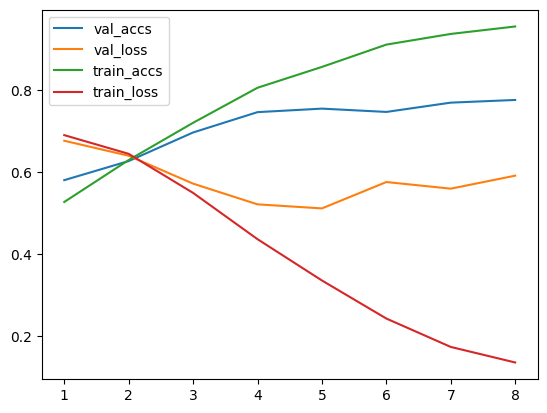

Training:  25%|██▌       | 2/8 [00:10<01:03, 10.63s/it, Training batch 1/78]                                

Epoch 1/8 | Train Loss: 0.679 Train Acc: 0.560 | Val Loss: 0.658 Val Acc: 0.606


Training:  50%|█████     | 4/8 [00:24<00:31,  7.79s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.594 Train Acc: 0.681 | Val Loss: 0.603 Val Acc: 0.666


Training:  62%|██████▎   | 5/8 [00:35<00:20,  6.76s/it, Training batch 1/78]                                

Epoch 3/8 | Train Loss: 0.477 Train Acc: 0.772 | Val Loss: 0.543 Val Acc: 0.734


Training:  88%|████████▊ | 7/8 [00:47<00:08,  8.09s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.397 Train Acc: 0.826 | Val Loss: 0.545 Val Acc: 0.723


Training: 100%|██████████| 8/8 [00:59<00:00,  7.17s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.323 Train Acc: 0.865 | Val Loss: 0.538 Val Acc: 0.763


Training: 9it [01:11,  8.37s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.235 Train Acc: 0.910 | Val Loss: 0.544 Val Acc: 0.761


Training: 11it [01:23,  9.27s/it, Training batch 1/78]                                

Epoch 7/8 | Train Loss: 0.169 Train Acc: 0.938 | Val Loss: 0.600 Val Acc: 0.780


Training: 100%|██████████| 8/8 [01:36<00:00, 12.02s/it, Validation Loss: 0.615 | Validation Accuracy: 0.762]


Epoch 8/8 | Train Loss: 0.128 Train Acc: 0.958 | Val Loss: 0.615 Val Acc: 0.762
Results for LSTM with layers = 1 and hidden size = 128 : test accuracy = 0.76 | train accuracy = 0.98 | training time = 96.19540214538574
--------------------------------------------------------------------------------------------------


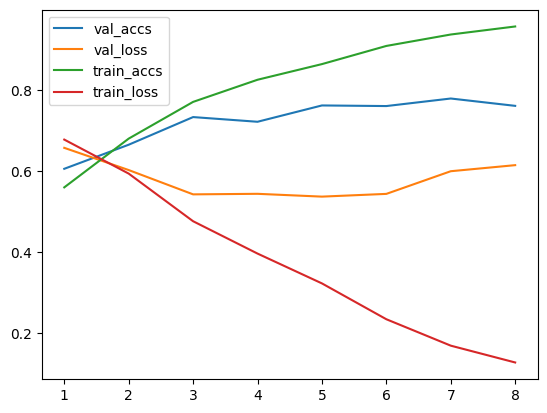

Training:  25%|██▌       | 2/8 [00:08<00:47,  8.00s/it, Training batch 2/78]                                

Epoch 1/8 | Train Loss: 0.690 Train Acc: 0.539 | Val Loss: 0.680 Val Acc: 0.581


Training:  50%|█████     | 4/8 [00:16<00:21,  5.27s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.634 Train Acc: 0.645 | Val Loss: 0.596 Val Acc: 0.683


Training:  62%|██████▎   | 5/8 [00:25<00:14,  4.89s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.509 Train Acc: 0.757 | Val Loss: 0.537 Val Acc: 0.725


Training:  88%|████████▊ | 7/8 [00:33<00:05,  5.67s/it, Training batch 2/78]                                

Epoch 4/8 | Train Loss: 0.390 Train Acc: 0.834 | Val Loss: 0.506 Val Acc: 0.762


Training: 100%|██████████| 8/8 [00:41<00:00,  4.97s/it, Training batch 2/78]                                

Epoch 5/8 | Train Loss: 0.293 Train Acc: 0.885 | Val Loss: 0.519 Val Acc: 0.769


Training: 9it [00:49,  5.61s/it, Training batch 2/78]                                                       

Epoch 6/8 | Train Loss: 0.226 Train Acc: 0.920 | Val Loss: 0.535 Val Acc: 0.756


Training: 11it [00:57,  6.20s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.157 Train Acc: 0.949 | Val Loss: 0.580 Val Acc: 0.776


Training: 100%|██████████| 8/8 [01:05<00:00,  8.14s/it, Validation Loss: 0.704 | Validation Accuracy: 0.765]


Epoch 8/8 | Train Loss: 0.104 Train Acc: 0.971 | Val Loss: 0.704 Val Acc: 0.765
Results for LSTM with layers = 2 and hidden size = 32 : test accuracy = 0.76 | train accuracy = 0.99 | training time = 65.10963344573975
--------------------------------------------------------------------------------------------------


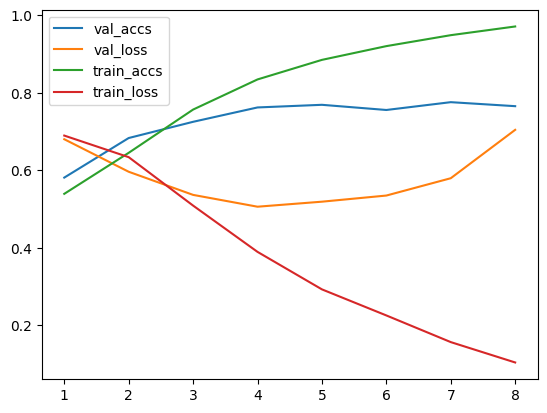

Training:  25%|██▌       | 2/8 [00:12<01:13, 12.22s/it, Training batch 1/78]                                

Epoch 1/8 | Train Loss: 0.677 Train Acc: 0.568 | Val Loss: 0.638 Val Acc: 0.632


Training:  50%|█████     | 4/8 [00:24<00:31,  7.83s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.582 Train Acc: 0.697 | Val Loss: 0.561 Val Acc: 0.708


Training:  62%|██████▎   | 5/8 [00:37<00:20,  6.95s/it, Training batch 1/78]                                

Epoch 3/8 | Train Loss: 0.474 Train Acc: 0.777 | Val Loss: 0.522 Val Acc: 0.737


Training:  88%|████████▊ | 7/8 [00:49<00:08,  8.45s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.361 Train Acc: 0.846 | Val Loss: 0.551 Val Acc: 0.763


Training: 100%|██████████| 8/8 [01:02<00:00,  7.50s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.269 Train Acc: 0.896 | Val Loss: 0.587 Val Acc: 0.768


Training: 9it [01:14,  8.68s/it, Validation Loss: 0.586 | Validation Accuracy: 0.781]                       

Epoch 6/8 | Train Loss: 0.182 Train Acc: 0.934 | Val Loss: 0.586 Val Acc: 0.781


Training: 11it [01:31, 10.82s/it, Training batch 1/78]                                

Epoch 7/8 | Train Loss: 0.152 Train Acc: 0.946 | Val Loss: 0.627 Val Acc: 0.773


Training: 100%|██████████| 8/8 [01:43<00:00, 12.93s/it, Validation Loss: 0.786 | Validation Accuracy: 0.773]


Epoch 8/8 | Train Loss: 0.080 Train Acc: 0.976 | Val Loss: 0.786 Val Acc: 0.773
Results for LSTM with layers = 2 and hidden size = 64 : test accuracy = 0.77 | train accuracy = 0.99 | training time = 103.41989874839783
--------------------------------------------------------------------------------------------------


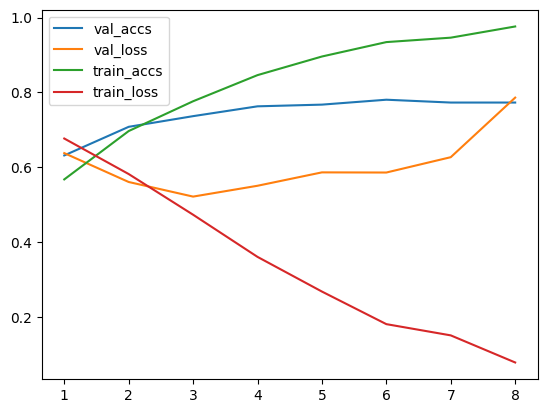

Training:  25%|██▌       | 2/8 [00:21<02:09, 21.61s/it, Training batch 0/78]                                

Epoch 1/8 | Train Loss: 0.672 Train Acc: 0.586 | Val Loss: 0.658 Val Acc: 0.613


Training:  50%|█████     | 4/8 [00:44<00:55, 13.91s/it, Training batch 0/78]                                

Epoch 2/8 | Train Loss: 0.576 Train Acc: 0.704 | Val Loss: 0.578 Val Acc: 0.693


Training:  62%|██████▎   | 5/8 [01:06<00:37, 12.54s/it, Training batch 0/78]                                

Epoch 3/8 | Train Loss: 0.468 Train Acc: 0.780 | Val Loss: 0.577 Val Acc: 0.723


Training:  88%|████████▊ | 7/8 [01:28<00:15, 15.14s/it, Training batch 0/78]                                

Epoch 4/8 | Train Loss: 0.356 Train Acc: 0.843 | Val Loss: 0.558 Val Acc: 0.735


Training: 100%|██████████| 8/8 [01:50<00:00, 13.38s/it, Training batch 0/78]                                

Epoch 5/8 | Train Loss: 0.280 Train Acc: 0.884 | Val Loss: 0.625 Val Acc: 0.744


Training: 9it [02:12, 15.40s/it, Training batch 0/78]                                                       

Epoch 6/8 | Train Loss: 0.171 Train Acc: 0.936 | Val Loss: 0.692 Val Acc: 0.735


Training: 11it [02:34, 16.97s/it, Training batch 0/78]                                

Epoch 7/8 | Train Loss: 0.095 Train Acc: 0.969 | Val Loss: 0.831 Val Acc: 0.751


Training: 100%|██████████| 8/8 [02:56<00:00, 22.12s/it, Validation Loss: 1.025 | Validation Accuracy: 0.764]


Epoch 8/8 | Train Loss: 0.052 Train Acc: 0.983 | Val Loss: 1.025 Val Acc: 0.764
Results for LSTM with layers = 2 and hidden size = 128 : test accuracy = 0.76 | train accuracy = 0.98 | training time = 176.9664294719696
--------------------------------------------------------------------------------------------------


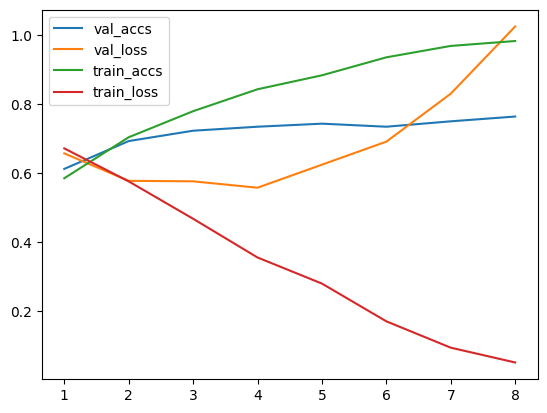

In [255]:
layers = [1, 2]
hidden_size = [32,64,128]
    
scores_test = np.zeros((2, 3))
scores_train = np.zeros((2, 3))

for i, layer in enumerate(layers):
    for j, hid_size in enumerate(hidden_size):
        model = LSTMModel(input_dim, 1, hid_size, maxlen, layer, 0.1)
        start = time.time()
        epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss = train_model(model, train_loader, valid_loader)
        end = time.time()

        _, test_acc = validate(model, test_loader)
        _, train_acc = validate(model, train_loader)

        print(f'Results for LSTM with layers = {layer} and hidden size = {hid_size} : test accuracy = {"{:.2f}".format(test_acc)} | train accuracy = {"{:.2f}".format(train_acc)} | training time = {end - start}')
        print("--------------------------------------------------------------------------------------------------")
        scores_test[i][j]=test_acc
        scores_train[i][j]=train_acc 
        epoch_num = [i+1 for i in range(8) ]
 
        plt.plot(epoch_num, epoch_val_accs, label='val_accs')
        plt.plot(epoch_num, epoch_val_loss,  label='val_loss')
        plt.plot(epoch_num, epoch_train_accs, label='train_accs')
        plt.plot(epoch_num, epoch_train_loss,  label='train_loss')
        plt.legend(loc='best')
        plt.show()

None
None


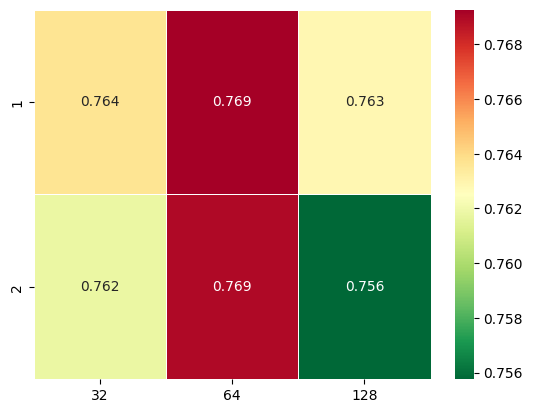

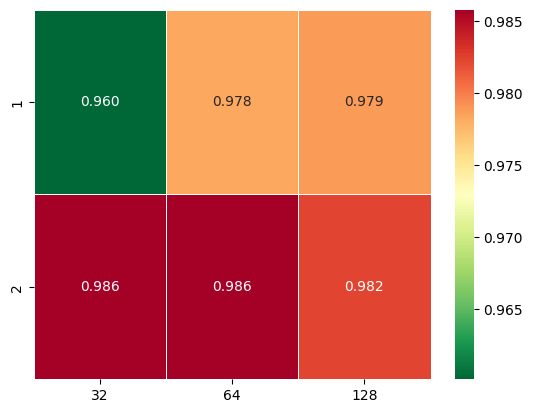

In [256]:
print(heatmap(hidden_size, layers, scores_test)) 
print(heatmap(hidden_size, layers, scores_train)) 

# Vanilla RNN

In [257]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True, nonlinearity='relu')  
        #self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.rnn(x)
        o = o[:, -1, :]
        #o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)
        return o


In [258]:
model = RNNModel(input_dim, 1, 128, maxlen, 2, 0.1)
print(model)

RNNModel(
  (embedding): Embedding(20000, 100)
  (rnn): RNN(100, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [259]:
epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss =  train_model(model, train_loader, valid_loader)

Training:  25%|██▌       | 2/8 [00:25<02:32, 25.38s/it, Training batch 0/78]                                

Epoch 1/8 | Train Loss: 0.687 Train Acc: 0.534 | Val Loss: 0.677 Val Acc: 0.561


Training:  50%|█████     | 4/8 [00:47<00:59, 14.88s/it, Training batch 0/78]                                

Epoch 2/8 | Train Loss: 0.648 Train Acc: 0.611 | Val Loss: 0.652 Val Acc: 0.594


Training:  62%|██████▎   | 5/8 [01:01<00:32, 10.75s/it, Training batch 1/78]                                

Epoch 3/8 | Train Loss: 0.570 Train Acc: 0.693 | Val Loss: 0.655 Val Acc: 0.603


Training:  88%|████████▊ | 7/8 [01:14<00:11, 11.30s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.475 Train Acc: 0.776 | Val Loss: 0.677 Val Acc: 0.633


Training: 100%|██████████| 8/8 [01:27<00:00,  9.16s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.370 Train Acc: 0.838 | Val Loss: 0.769 Val Acc: 0.646


Training: 9it [01:39,  9.96s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.254 Train Acc: 0.902 | Val Loss: 0.849 Val Acc: 0.647


Training: 11it [01:52, 10.76s/it, Training batch 0/78]                                

Epoch 7/8 | Train Loss: 0.175 Train Acc: 0.930 | Val Loss: 1.002 Val Acc: 0.639


Training: 100%|██████████| 8/8 [02:06<00:00, 15.77s/it, Validation Loss: 1.244 | Validation Accuracy: 0.647]

Epoch 8/8 | Train Loss: 0.121 Train Acc: 0.958 | Val Loss: 1.244 Val Acc: 0.647


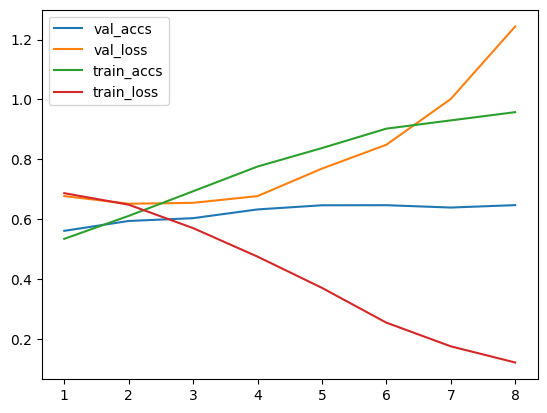

In [260]:
epoch_num = [i+1 for i in range(8) ]
 
plt.plot(epoch_num, epoch_val_accs, label='val_accs')
plt.plot(epoch_num, epoch_val_loss,  label='val_loss')
plt.plot(epoch_num, epoch_train_accs, label='train_accs')
plt.plot(epoch_num, epoch_train_loss,  label='train_loss')
plt.legend(loc='best')
plt.show()

c:\Users\karol\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Training:  25%|██▌       | 2/8 [00:06<00:40,  6.77s/it, Training batch 2/78]                                

Epoch 1/8 | Train Loss: 0.697 Train Acc: 0.516 | Val Loss: 0.686 Val Acc: 0.539


Training:  50%|█████     | 4/8 [00:13<00:16,  4.05s/it, Training batch 3/78]                                

Epoch 2/8 | Train Loss: 0.666 Train Acc: 0.589 | Val Loss: 0.674 Val Acc: 0.568


Training:  62%|██████▎   | 5/8 [00:18<00:10,  3.45s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.633 Train Acc: 0.650 | Val Loss: 0.664 Val Acc: 0.584


Training:  88%|████████▊ | 7/8 [00:24<00:03,  3.99s/it, Training batch 3/78]                                

Epoch 4/8 | Train Loss: 0.587 Train Acc: 0.692 | Val Loss: 0.648 Val Acc: 0.602


Training: 100%|██████████| 8/8 [00:29<00:00,  3.38s/it, Training batch 2/78]                                

Epoch 5/8 | Train Loss: 0.522 Train Acc: 0.745 | Val Loss: 0.629 Val Acc: 0.646


Training: 9it [00:34,  3.71s/it, Training batch 3/78]                                                       

Epoch 6/8 | Train Loss: 0.453 Train Acc: 0.786 | Val Loss: 0.634 Val Acc: 0.656


Training: 11it [00:39,  4.08s/it, Training batch 1/78]                                

Epoch 7/8 | Train Loss: 0.378 Train Acc: 0.834 | Val Loss: 0.634 Val Acc: 0.673


Training: 100%|██████████| 8/8 [00:44<00:00,  5.53s/it, Validation Loss: 0.653 | Validation Accuracy: 0.693]


Epoch 8/8 | Train Loss: 0.303 Train Acc: 0.876 | Val Loss: 0.653 Val Acc: 0.693
Results for RNN with layers = 1 and hidden size = 32 : test accuracy = 0.69 | train accuracy = 0.91 | training time = 44.211222410202026
--------------------------------------------------------------------------------------------------


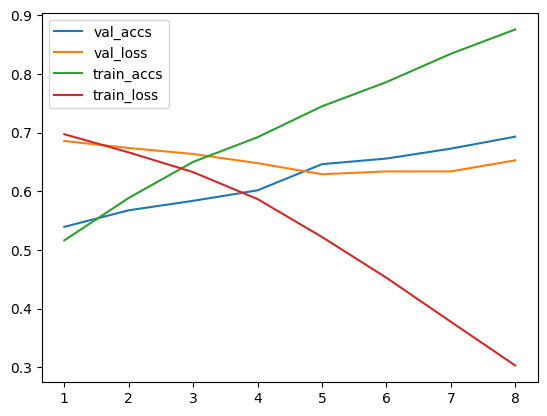

Training:  25%|██▌       | 2/8 [00:08<00:51,  8.54s/it, Training batch 2/78]                                

Epoch 1/8 | Train Loss: 0.693 Train Acc: 0.528 | Val Loss: 0.680 Val Acc: 0.562


Training:  50%|█████     | 4/8 [00:16<00:20,  5.11s/it, Training batch 2/78]                                

Epoch 2/8 | Train Loss: 0.651 Train Acc: 0.622 | Val Loss: 0.664 Val Acc: 0.597


Training:  62%|██████▎   | 5/8 [00:22<00:12,  4.02s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.599 Train Acc: 0.684 | Val Loss: 0.640 Val Acc: 0.619


Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.49s/it, Training batch 2/78]                                

Epoch 4/8 | Train Loss: 0.524 Train Acc: 0.747 | Val Loss: 0.626 Val Acc: 0.649


Training: 100%|██████████| 8/8 [00:34<00:00,  3.79s/it, Training batch 2/78]                                

Epoch 5/8 | Train Loss: 0.441 Train Acc: 0.804 | Val Loss: 0.617 Val Acc: 0.657


Training: 9it [00:39,  4.29s/it, Training batch 2/78]                                                       

Epoch 6/8 | Train Loss: 0.366 Train Acc: 0.847 | Val Loss: 0.631 Val Acc: 0.690


Training: 11it [00:45,  4.69s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.291 Train Acc: 0.877 | Val Loss: 0.666 Val Acc: 0.694


Training: 100%|██████████| 8/8 [00:51<00:00,  6.45s/it, Validation Loss: 0.763 | Validation Accuracy: 0.699]


Epoch 8/8 | Train Loss: 0.234 Train Acc: 0.913 | Val Loss: 0.763 Val Acc: 0.699
Results for RNN with layers = 1 and hidden size = 64 : test accuracy = 0.70 | train accuracy = 0.94 | training time = 51.591368675231934
--------------------------------------------------------------------------------------------------


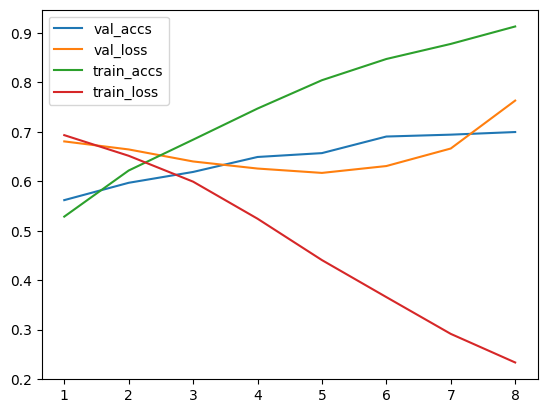

Training:  25%|██▌       | 2/8 [00:13<01:18, 13.08s/it, Training batch 1/78]                                

Epoch 1/8 | Train Loss: 0.683 Train Acc: 0.551 | Val Loss: 0.670 Val Acc: 0.566


Training:  50%|█████     | 4/8 [00:22<00:26,  6.64s/it, Training batch 2/78]                                

Epoch 2/8 | Train Loss: 0.622 Train Acc: 0.646 | Val Loss: 0.637 Val Acc: 0.605


Training:  62%|██████▎   | 5/8 [00:30<00:16,  5.35s/it, Training batch 1/78]                                

Epoch 3/8 | Train Loss: 0.542 Train Acc: 0.732 | Val Loss: 0.630 Val Acc: 0.638


Training:  88%|████████▊ | 7/8 [00:37<00:05,  5.92s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.463 Train Acc: 0.782 | Val Loss: 0.658 Val Acc: 0.651


Training: 100%|██████████| 8/8 [00:45<00:00,  5.05s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.379 Train Acc: 0.831 | Val Loss: 0.645 Val Acc: 0.682


Training: 9it [00:53,  5.68s/it, Training batch 2/78]                                                       

Epoch 6/8 | Train Loss: 0.287 Train Acc: 0.886 | Val Loss: 0.696 Val Acc: 0.679


Training: 11it [01:01,  6.19s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.205 Train Acc: 0.925 | Val Loss: 0.760 Val Acc: 0.687


Training: 100%|██████████| 8/8 [01:08<00:00,  8.58s/it, Validation Loss: 0.814 | Validation Accuracy: 0.678]


Epoch 8/8 | Train Loss: 0.151 Train Acc: 0.946 | Val Loss: 0.814 Val Acc: 0.678
Results for RNN with layers = 1 and hidden size = 128 : test accuracy = 0.68 | train accuracy = 0.99 | training time = 68.64253616333008
--------------------------------------------------------------------------------------------------


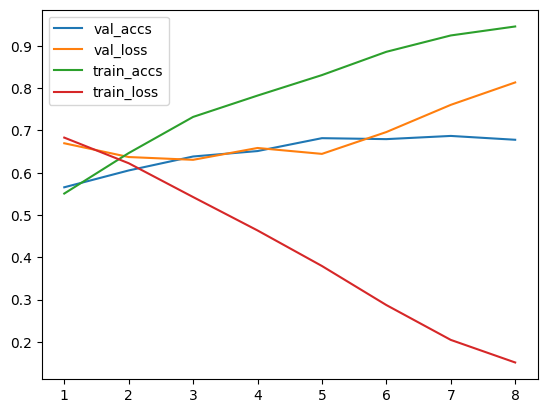

Training:  25%|██▌       | 2/8 [00:08<00:47,  7.90s/it, Training batch 2/78]                                

Epoch 1/8 | Train Loss: 0.691 Train Acc: 0.511 | Val Loss: 0.684 Val Acc: 0.559


Training:  50%|█████     | 4/8 [00:15<00:19,  4.87s/it, Training batch 2/78]                                

Epoch 2/8 | Train Loss: 0.674 Train Acc: 0.585 | Val Loss: 0.674 Val Acc: 0.575


Training:  62%|██████▎   | 5/8 [00:22<00:12,  4.05s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.639 Train Acc: 0.636 | Val Loss: 0.663 Val Acc: 0.580


Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.59s/it, Training batch 2/78]                                

Epoch 4/8 | Train Loss: 0.588 Train Acc: 0.685 | Val Loss: 0.653 Val Acc: 0.600


Training: 100%|██████████| 8/8 [00:34<00:00,  4.05s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.518 Train Acc: 0.736 | Val Loss: 0.660 Val Acc: 0.619


Training: 9it [00:42,  4.78s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.458 Train Acc: 0.781 | Val Loss: 0.679 Val Acc: 0.634


Training: 11it [00:48,  5.19s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.377 Train Acc: 0.837 | Val Loss: 0.761 Val Acc: 0.657


Training: 100%|██████████| 8/8 [00:54<00:00,  6.84s/it, Validation Loss: 0.717 | Validation Accuracy: 0.680]


Epoch 8/8 | Train Loss: 0.305 Train Acc: 0.871 | Val Loss: 0.717 Val Acc: 0.680
Results for RNN with layers = 2 and hidden size = 32 : test accuracy = 0.68 | train accuracy = 0.93 | training time = 54.73798966407776
--------------------------------------------------------------------------------------------------


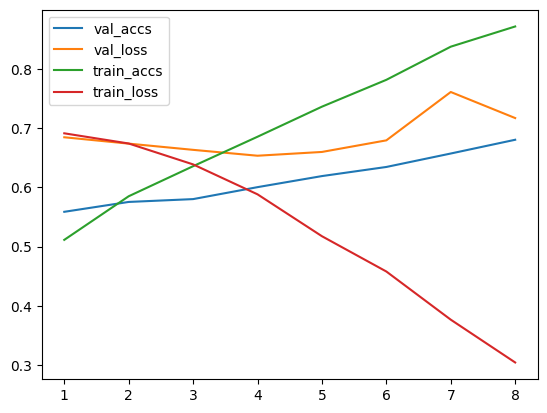

Training:  25%|██▌       | 2/8 [00:11<01:10, 11.74s/it, Training batch 1/78]                                

Epoch 1/8 | Train Loss: 0.691 Train Acc: 0.529 | Val Loss: 0.686 Val Acc: 0.542


Training:  50%|█████     | 4/8 [00:22<00:27,  6.96s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.662 Train Acc: 0.601 | Val Loss: 0.679 Val Acc: 0.555


Training:  62%|██████▎   | 5/8 [00:30<00:16,  5.54s/it, Training batch 2/78]                                

Epoch 3/8 | Train Loss: 0.609 Train Acc: 0.662 | Val Loss: 0.660 Val Acc: 0.599


Training:  88%|████████▊ | 7/8 [00:39<00:06,  6.25s/it, Training batch 2/78]                                

Epoch 4/8 | Train Loss: 0.539 Train Acc: 0.726 | Val Loss: 0.667 Val Acc: 0.619


Training: 100%|██████████| 8/8 [00:47<00:00,  5.30s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.462 Train Acc: 0.781 | Val Loss: 0.729 Val Acc: 0.636


Training: 9it [00:55,  6.03s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.377 Train Acc: 0.836 | Val Loss: 0.765 Val Acc: 0.649


Training: 11it [01:04,  6.69s/it, Training batch 2/78]                                

Epoch 7/8 | Train Loss: 0.301 Train Acc: 0.869 | Val Loss: 0.768 Val Acc: 0.648


Training: 100%|██████████| 8/8 [01:12<00:00,  9.02s/it, Validation Loss: 0.845 | Validation Accuracy: 0.646]


Epoch 8/8 | Train Loss: 0.226 Train Acc: 0.908 | Val Loss: 0.845 Val Acc: 0.646
Results for RNN with layers = 2 and hidden size = 64 : test accuracy = 0.66 | train accuracy = 0.96 | training time = 72.15741515159607
--------------------------------------------------------------------------------------------------


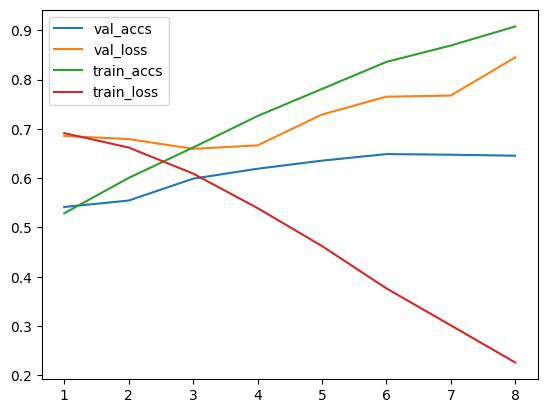

Training:  25%|██▌       | 2/8 [00:22<02:17, 22.92s/it, Training batch 0/78]                                

Epoch 1/8 | Train Loss: 0.686 Train Acc: 0.540 | Val Loss: 0.668 Val Acc: 0.577


Training:  50%|█████     | 4/8 [00:36<00:42, 10.73s/it, Training batch 1/78]                                

Epoch 2/8 | Train Loss: 0.636 Train Acc: 0.632 | Val Loss: 0.643 Val Acc: 0.609


Training:  62%|██████▎   | 5/8 [00:48<00:25,  8.47s/it, Training batch 1/78]                                

Epoch 3/8 | Train Loss: 0.555 Train Acc: 0.717 | Val Loss: 0.633 Val Acc: 0.637


Training:  88%|████████▊ | 7/8 [01:00<00:09,  9.44s/it, Training batch 1/78]                                

Epoch 4/8 | Train Loss: 0.450 Train Acc: 0.787 | Val Loss: 0.645 Val Acc: 0.623


Training: 100%|██████████| 8/8 [01:12<00:00,  7.97s/it, Training batch 1/78]                                

Epoch 5/8 | Train Loss: 0.360 Train Acc: 0.851 | Val Loss: 0.696 Val Acc: 0.617


Training: 9it [01:24,  8.93s/it, Training batch 1/78]                                                       

Epoch 6/8 | Train Loss: 0.258 Train Acc: 0.895 | Val Loss: 0.831 Val Acc: 0.653


Training: 11it [01:37,  9.77s/it, Training batch 1/78]                                

Epoch 7/8 | Train Loss: 0.145 Train Acc: 0.948 | Val Loss: 1.088 Val Acc: 0.665


Training: 100%|██████████| 8/8 [01:49<00:00, 13.63s/it, Validation Loss: 1.187 | Validation Accuracy: 0.665]


Epoch 8/8 | Train Loss: 0.095 Train Acc: 0.966 | Val Loss: 1.187 Val Acc: 0.665
Results for RNN with layers = 2 and hidden size = 128 : test accuracy = 0.66 | train accuracy = 0.99 | training time = 109.06624913215637
--------------------------------------------------------------------------------------------------


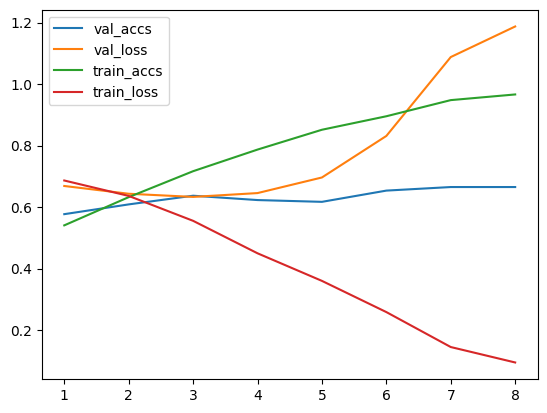

In [261]:
layers = [1, 2]
hidden_size = [32,64,128]
    
scores_test = np.zeros((2, 3))
scores_train = np.zeros((2, 3))

for i, layer in enumerate(layers):
    for j, hid_size in enumerate(hidden_size):
        model = RNNModel(input_dim, 1, hid_size, maxlen, layer, 0.1)
        start = time.time()
        epoch_val_accs, epoch_train_accs, epoch_val_loss, epoch_train_loss = train_model(model, train_loader, valid_loader)
        end = time.time()

        _, test_acc = validate(model, test_loader)
        _, train_acc = validate(model, train_loader)

        print(f'Results for RNN with layers = {layer} and hidden size = {hid_size} : test accuracy = {"{:.2f}".format(test_acc)} | train accuracy = {"{:.2f}".format(train_acc)} | training time = {end - start}')
        print("--------------------------------------------------------------------------------------------------")
        scores_test[i][j]=test_acc
        scores_train[i][j]=train_acc 
        epoch_num = [i+1 for i in range(8) ]
 
        plt.plot(epoch_num, epoch_val_accs, label='val_accs')
        plt.plot(epoch_num, epoch_val_loss,  label='val_loss')
        plt.plot(epoch_num, epoch_train_accs, label='train_accs')
        plt.plot(epoch_num, epoch_train_loss,  label='train_loss')
        plt.legend(loc='best')
        plt.show()

None
None


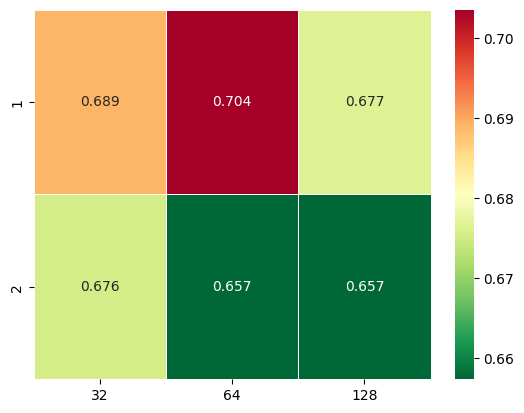

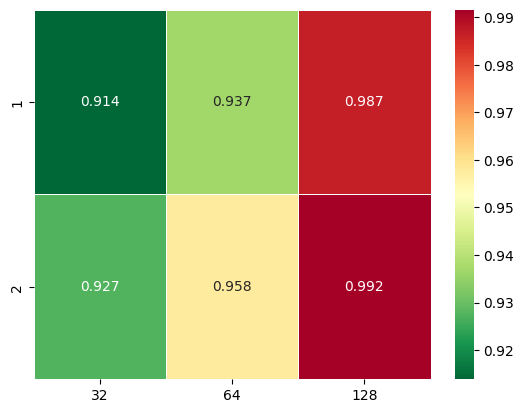

In [262]:
print(heatmap(hidden_size, layers, scores_test)) 
print(heatmap(hidden_size, layers, scores_train)) 

# Vanilla RNN in Keras

In [120]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense,Activation,Embedding

In [121]:
rnn = Sequential()
rnn.add(Embedding(input_dim,32,input_length = maxlen)) 
rnn.add(SimpleRNN(16,input_shape = (input_dim,maxlen), return_sequences=False,activation="relu"))
rnn.add(Dense(1)) 
rnn.add(Activation("sigmoid"))

print(rnn.summary())
rnn.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 640801 (2.44 MB)
Trainable params: 640801 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



In [156]:
history = rnn.fit(x_train,y_train_all,validation_data = (x_test,y_test_all),epochs = 5,batch_size=128,verbose = 1)

Epoch 1/5
196/196 [==============================] - 5s 16ms/step - loss: 0.3337 - accuracy: 0.8545 - val_loss: 0.4971 - val_accuracy: 0.7783
Epoch 2/5
196/196 [==============================] - 3s 17ms/step - loss: 0.2817 - accuracy: 0.8830 - val_loss: 0.4952 - val_accuracy: 0.7848
Epoch 3/5
196/196 [==============================] - 4s 19ms/step - loss: 0.2431 - accuracy: 0.9008 - val_loss: 0.4959 - val_accuracy: 0.7782
Epoch 4/5
196/196 [==============================] - 3s 17ms/step - loss: 0.2106 - accuracy: 0.9188 - val_loss: 0.5811 - val_accuracy: 0.7726
Epoch 5/5
196/196 [==============================] - 3s 14ms/step - loss: 0.1812 - accuracy: 0.9300 - val_loss: 0.5544 - val_accuracy: 0.7786


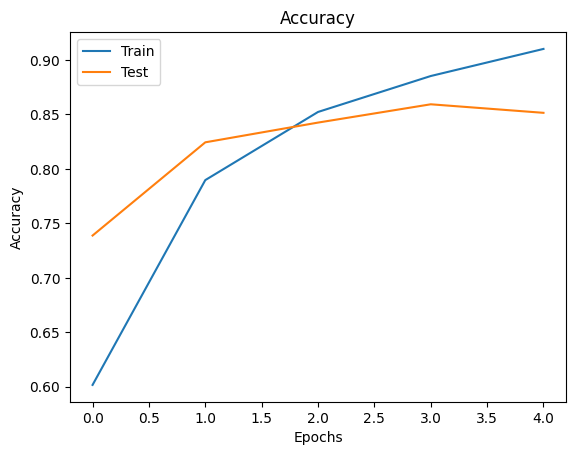

In [124]:
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

## Batch padding - padding sequences lenght to max sequence lenght in each batch

In [221]:
i=0
batches_x,batches_y = [],[]
while ((i+1)*batch_size<len(x_train_all)/10):
    batch_x = x_train_all[i*batch_size:(i+1)*batch_size]
    max_length = max(len(seq) for seq in batch_x)
    x = tf.keras.preprocessing.sequence.pad_sequences(batch_x, maxlen=max_length)
    batches_x.append(torch.tensor(x))

    batch_y = y_train_all[i*batch_size:(i+1)*batch_size]
    batches_y.append(torch.tensor(batch_y))

    i+=1

train_loader_pad=zip(batches_x,batches_y)

In [225]:
def train_model_batch_padding(model, batches_x,batches_y, valid_loader, lr = 0.001, epochs = 8):
    loss_fn = nn.BCELoss()
    optim = Adam(model.parameters(), lr=lr)
    grad_clip = 5

    epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

    for e in epochloop:

        model.train()
        train_loss = 0
        train_acc = 0

        for i, (x, y) in enumerate(zip(batches_x,batches_y)):
            
            
            epochloop.set_postfix_str(f'Training batch {i}/{len(batches_x)}')

            optim.zero_grad()

            output = model(x)

            predicted = torch.tensor([1 if ii == True else 0 for ii in output > 0.5])
            equals = predicted == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()
            loss = loss_fn(output.squeeze(), y.float())
            train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optim.step()

            del x, y, predicted
        val_loss, val_acc = validate(valid_loader)
        epochloop.set_postfix_str(f'Validation Loss: {val_loss:.3f} | Validation Accuracy: {val_acc:.3f}')
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(batches_x):.3f} Train Acc: {train_acc / len(batches_x):.3f} | Val Loss: {val_loss:.3f} Val Acc: {val_acc:.3f}')
        epochloop.update()    

      
def validate(model, valid_loader):
    loss_fn = nn.BCELoss()
    
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            
            output = model(x)
            predicted = torch.tensor([1 if ii == True else 0 for ii in output > 0.5])
            equals = predicted == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()
            loss = loss_fn(output.squeeze(), y.float())
            val_loss += loss.item()

            del x, y, predicted
    return val_loss/len(valid_loader), val_acc/len(valid_loader)

In [223]:
model = LSTMModel(input_dim, 1, 128, maxlen, 2, 0.1)
train_model_batch_padding(model, batches_x,batches_y, valid_loader)

Training:   0%|          | 0/8 [00:00<?, ?it/s, Training batch 0/156]

Training:  25%|██▌       | 2/8 [03:30<21:04, 210.80s/it, Training batch 0/156]                               

Epoch 1/8 | Train Loss: 0.691 Train Acc: 0.532 | Val Loss: 0.684 Val Acc: 0.570


Training:  50%|█████     | 4/8 [07:06<08:57, 134.39s/it, Training batch 0/156]                               

Epoch 2/8 | Train Loss: 0.672 Train Acc: 0.589 | Val Loss: 0.666 Val Acc: 0.594


Training:  62%|██████▎   | 5/8 [10:50<06:09, 123.05s/it, Training batch 0/156]                               

Epoch 3/8 | Train Loss: 0.628 Train Acc: 0.650 | Val Loss: 0.646 Val Acc: 0.620


Training:  88%|████████▊ | 7/8 [14:34<02:30, 150.05s/it, Training batch 0/156]                               

Epoch 4/8 | Train Loss: 0.566 Train Acc: 0.702 | Val Loss: 0.656 Val Acc: 0.630


Training: 100%|██████████| 8/8 [18:08<00:00, 131.49s/it, Training batch 0/156]                               

Epoch 5/8 | Train Loss: 0.496 Train Acc: 0.759 | Val Loss: 0.647 Val Acc: 0.653


Training: 9it [21:20, 145.74s/it, Training batch 0/156]                                                      

Epoch 6/8 | Train Loss: 0.413 Train Acc: 0.813 | Val Loss: 0.722 Val Acc: 0.667


Training: 11it [24:36, 158.31s/it, Training batch 0/156]                               

Epoch 7/8 | Train Loss: 0.328 Train Acc: 0.861 | Val Loss: 0.790 Val Acc: 0.666


Training: 100%|██████████| 8/8 [27:05<00:00, 203.14s/it, Validation Loss: 1.059 | Validation Accuracy: 0.671]

Epoch 8/8 | Train Loss: 0.258 Train Acc: 0.896 | Val Loss: 1.059 Val Acc: 0.671


In [226]:
test_loss, test_accuracy = validate(model, test_loader)
print(f'Test loss: {test_loss} | Test accuracy: {test_accuracy}')

Test loss: 1.1138456836771828 | Test accuracy: 0.6553502879078695
